In [404]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import time 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import accumulate
import math

class MuliRewardMultiArmedBandit(gym.Env):
    """
    An adaptation of the K-armed bandit 
    - k_arms:     bandits (actions)
    - m_rewards:  reward functions 

    All rewards will be sampled from a Normal distrabution with a random mean choosen uniformly between [0,1] amd std of 1

    optional paramters:
    - seed:       the seed used to generate the reward (samples from the distrabution). This enables the same rewards the be observed again (assuming same actions)
    """
    metadata = {"name": "MuliRewardMultiArmedBandit-v0"} # for "publishing" to gymnasium

    # alt function sig
    # def __init__(self, k_arms: int, m_rewards: int, render_mode = None, seed: int = 0, mean_seed: int = np.random.randint(1,1001)):
    # def __init__(self, k_arms: int, m_rewards: int, render_mode = None, seed: int = 0, mean_seed: int = 0):

    def __init__(self, k_arms: int, m_rewards: int, render_mode = None, seed: int = 0):

        super().__init__()
        self.arms = k_arms
        self.action_space = spaces.Discrete(k_arms) 
        self.observation_space = spaces.Discrete(1) 

        np.random.seed(1) # 
        self.means = [[np.random.uniform(0,1) for m in range(m_rewards)] for k in range(k_arms)]
        self.std = 1 # all will have a std of 1.

        np.random.seed(seed) # for reproducability of reward
        self.total = [0] * m_rewards # record of all the rewards 
        self.history = [] # which 

    #optionals should have the seed for the rewards samples
    def reset(self, seed = 0, options = None):
        super().reset(seed=seed) #change the seed for np.random?
        np.random.seed(seed) # reset the seed used for actions 
        self.history.clear()
        self.total = [0] * m_rewards 
        
        return 0, {} # stateless environemtn 
         
    def show_means(self):
        return self.means

    def get_history(self):
        return self.history

    def get_reward(self):
        return self.reward
        
    def step(self, action: int):
        next_state = 0 # no change
        terminated = False 
        truncated = False # time limit? o
        rewards = [np.random.normal(m, self.std) for m in self.means[action]]
        self.history.append(rewards)
        
        info = {"arm": action, "means": self.means[action]}
        
        return next_state, rewards, terminated, truncated, info

    def close(self):
        pass 
        

In [394]:
# test if seed works
k_arms = 5
m_rewards = 2
env = MuliRewardMultiArmedBandit(k_arms, m_rewards)
rewards = []

for i in range(10):
    rewards.append(env.step(1)[1])

rewards

[[1.764166720785009, 0.7024897809990631],
 [0.9788523589230841, 2.5432257718332973],
 [1.8676723649673124, -0.6749453072445712],
 [0.9502027923429343, 0.15097536433414188],
 [-0.10310447697621296, 0.7129310745702121],
 [0.14415794597822287, 1.7566060795948149],
 [0.7611520999643383, 0.4240075891246682],
 [0.44397760756277055, 0.6360069000061066],
 [1.494193447974951, 0.0971743088660389],
 [0.31318207646824625, -0.551763166669885]]

In [393]:
env.reset()

rewards = []

for i in range(10):
    rewards.append(env.step(1)[1])

rewards
    

[[1.764166720785009, 0.7024897809990631],
 [0.9788523589230841, 2.5432257718332973],
 [1.8676723649673124, -0.6749453072445712],
 [0.9502027923429343, 0.15097536433414188],
 [-0.10310447697621296, 0.7129310745702121],
 [0.14415794597822287, 1.7566060795948149],
 [0.7611520999643383, 0.4240075891246682],
 [0.44397760756277055, 0.6360069000061066],
 [1.494193447974951, 0.0971743088660389],
 [0.31318207646824625, -0.551763166669885]]

In [384]:
# no idea how this synatax sorks, I yoinked it from Korpans work 
def normalize(Q):
    return np.nan_to_num((Q-Q.min(0))/(Q.max(0)-Q.min(0)))

def range_voting(arr):
    scores = np.sum(arr, axis=1)
    min_score = np.min(scores)
    best_path = np.argmin(scores)
    # return scores, min_score, best_path
    return best_path

#Borda voting mechanism that takes normalized path costs, calculates the ranks for each column then the points (max rank + 1 - rank), then the total Borda scores
#it returns the total Borda scores, the maximum score, and the plan with the maximum score
def borda_voting(arr):
    s = pd.DataFrame(arr)
    ranks = s.rank(axis=0, method='dense')
    points = (ranks.shape[0]+1)-ranks
    borda_scores = np.sum(points, axis=1)
    best_path = np.argmax(borda_scores)
    max_score = np.sum(arr[best_path])
    # return borda_scores, max_score, best_path
    return best_path

#Combined approval voting mechanism that takes normalized path costs, assigns a value of 1 to plans with a normalized cost of 0, a value of -1 to plans with a normalized cost of 1, and a value of 0 otherwise
#it returns the total approval scores, the maximum score, and the plan with the maximum score
def combined_approval_voting(arr):
    l = arr.copy()
    l[l == 1] = -1
    l[(l < 1) & (l > 0)] = 11
    l[l == 0] = 1
    l[l == 11] = 0
    approval_scores = np.sum(l, axis=1)
    best_path = np.argmax(approval_scores)
    max_score = np.sum(arr[best_path])
    # return approval_scores, max_score, best_path
    return best_path

#Condorcet voting mecahnism has each candidate assigne points in assending order in order of preference, the lowest wins.
def condorcet_voting(arr):
    condorcet_scores = [0] * len(arr) 
    arr = [[(arr[i][j], i) for j in range (len(arr[0]))] for i in range(len(arr))] #cursed 

    for r in range(len(arr[0])):
        x = [l[r] for l in arr]
        x.sort()
        for i in range(len(x)):
            condorcet_scores[x[i][1]] += i # rewards for candidate i is perportional to its position in the sorted array (x[i][1])

    return condorcet_scores

def vote(vote_method, norm_data):
    match vote_method:
        case "Range":
            return range_voting(norm_data)
        case "Borda":
            return borda_voting(norm_data)
        case "Combined_Approval":
            return combined_approval_voting(norm_data)
        case "Condorcet":
            return condorcet_voting(norm_data)
        case _:
            raise ValueError(f"'{vote_method}' is not a valid voting method")


## Scalarized Q-Learning 
Q function is an unweighted sum of all reward cost estimates

In [399]:
k_arms = 5
m_rewards = 2
env = MuliRewardMultiArmedBandit(k_arms, m_rewards)

alpha = 0.1 # learning rate
epsilon = 0.1 # exploration rate
train_length = 1000

Q = np.zeros((k_arms, m_rewards))
record = np.zeros(k_arms)

# training
for episode in range(train_length):
    if np.random.rand() < epsilon:
        action = env.action_space.sample() 
    else:
        scalar_Q = np.sum(Q, axis=1)
        action = np.argmax(scalar_Q)

    next_state, rewards, terminated, truncated, info  = env.step(action)

    # updating Q table
    for m in range(m_rewards):
        Q[action, m] += alpha * (rewards[m] - Q[action, m])
    
    record[action] += 1

# test 
test_length = 100
total_rewards = np.zeros(m_rewards)
for _ in range(test_length):
    scalar_Q = np.sum(Q, axis=1)
    action = np.argmax(scalar_Q)
    _, rewards, _, _, _ = env.step(action)
    total_rewards += rewards #will this work?

means = env.show_means()

print(f"Rewards over {test_length} test episodes: {total_rewards}")
print(f"Average rewards over {test_length} test episodes: {total_rewards / test_length}")
print(f"Q-values:{'\n'}{Q}")
print(f"Means:")
for mean in means:
    print(mean)
print(f"Pull counts: {record}")

env.close()

Rewards over 100 test episodes: [30.3997725  70.88607995]
Average rewards over 100 test episodes: [0.30399772 0.7088608 ]
Q-values:
[[ 0.1546272   0.59952968]
 [ 0.11438398  0.01284056]
 [ 0.04065863 -0.25434443]
 [ 0.05344956  0.35804111]
 [ 0.48165302  0.03602343]]
Means:
[0.417022004702574, 0.7203244934421581]
[0.00011437481734488664, 0.30233257263183977]
[0.14675589081711304, 0.0923385947687978]
[0.1862602113776709, 0.34556072704304774]
[0.39676747423066994, 0.538816734003357]
Pull counts: [913.  19.  14.  32.  22.]


## Anaylsis 

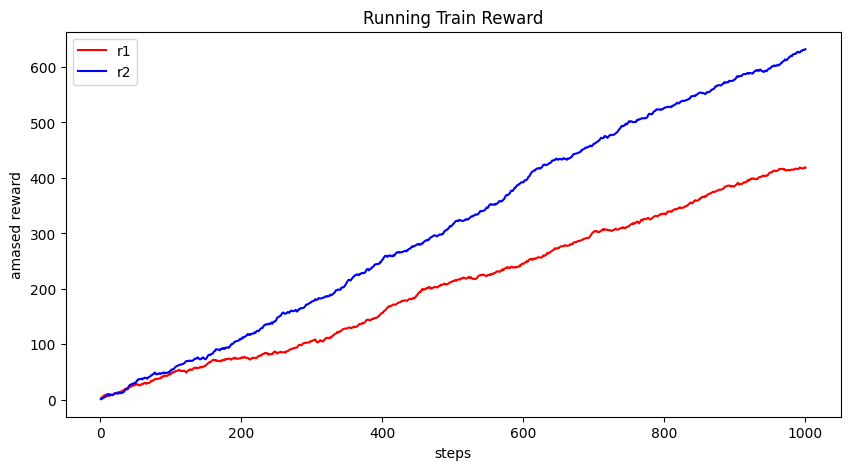

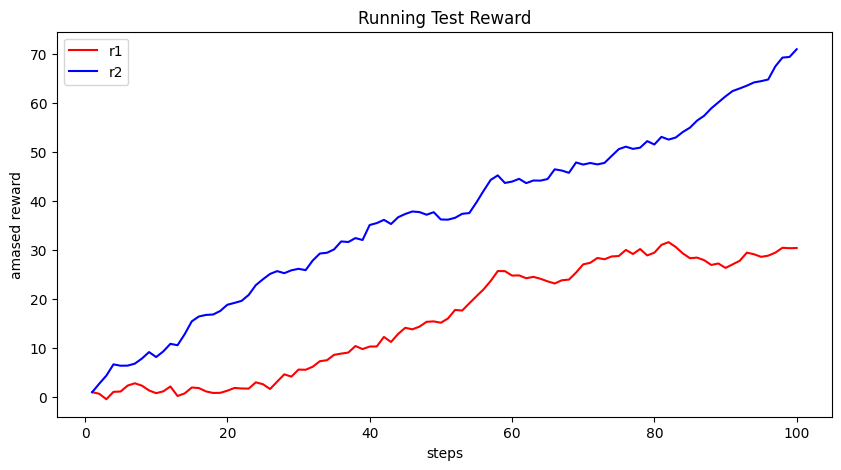

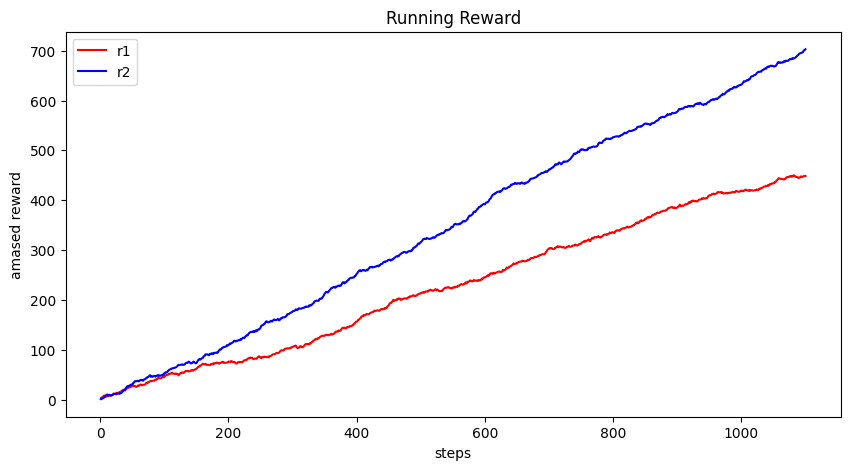

In [400]:
hist = env.get_history() 

r_1 = [h[0] for h in hist]
r_2 = [h[1] for h in hist]

r_1_running = list(accumulate(r_1))
r_2_running = list(accumulate(r_2))

r_1_train_running = list(accumulate(r_1[:train_length]))
r_1_test_running = list(accumulate(r_1[-test_length:]))

r_2_train_running = list(accumulate(r_2[:train_length]))
r_2_test_running = list(accumulate(r_2[-test_length:]))

X_train = np.arange(1, train_length+1)
X_test = np.arange(1, test_length+1)
X_total = np.arange(1, train_length+test_length+1)

plt.figure(figsize=(10, 5))
plt.title("Running Train Reward")
plt.xlabel("steps")
plt.ylabel("amased reward")
plt.plot(X_train, r_1_train_running, color='r', label='r1')
plt.plot(X_train, r_2_train_running, color='b', label='r2')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Running Test Reward")
plt.xlabel("steps")
plt.ylabel("amased reward")
plt.plot(X_test, r_1_test_running, color='r', label='r1')
plt.plot(X_test, r_2_test_running, color='b', label='r2')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Running Reward")
plt.xlabel("steps")
plt.ylabel("amased reward")
plt.plot(X_total, r_1_running, color='r', label='r1')
plt.plot(X_total, r_2_running, color='b', label='r2')
plt.legend()
plt.show()

In [402]:
env.reset() # seed is the same.

alpha = 0.1 # learning rate
epsilon = 0.1 # exploration rate
train_length = 1000
VOTE_METHODS = "Combined_Approval"

Q = np.zeros((k_arms, m_rewards))
record = np.zeros(k_arms)

# training
for episode in range(train_length):
    if np.random.rand() < epsilon:
        action = env.action_space.sample() 
    else:
        norm_Q = normalize(Q)
        action = vote(VOTE_METHODS, norm_Q)

    next_state, rewards, terminated, truncated, info  = env.step(action)

    # update Q table
    for m in range(2):
        Q[action, m] += alpha * (rewards[m] - Q[action, m])
    
    record[action] += 1

# test 
test_length = 100
total_rewards = np.zeros(m_rewards)
for _ in range(test_length):
    scalar_Q = np.sum(Q, axis=1)
    action = np.argmax(scalar_Q)
    _, rewards, _, _, _ = env.step(action)
    total_rewards += rewards #will this work?
    
means = env.show_means()

print(f"Rewards over {test_length} test episodes: {total_rewards}")
print(f"Average rewards over {test_length} test episodes: {total_rewards / test_length}")
print(f"Q-values:{'\n'}{Q}")
print(f"Means:")
for mean in means:
    print(mean)
print(f"Pull counts: {record}")

Rewards over 100 test episodes: [30.3997725  70.88607995]
Average rewards over 100 test episodes: [0.30399772 0.7088608 ]
Q-values:
[[ 0.18591089  1.08566717]
 [-0.25550386  0.18526975]
 [ 0.34178007  0.23196392]
 [ 0.60550472  0.31895819]
 [ 0.59539699  0.41856621]]
Means:
[0.417022004702574, 0.7203244934421581]
[0.00011437481734488664, 0.30233257263183977]
[0.14675589081711304, 0.0923385947687978]
[0.1862602113776709, 0.34556072704304774]
[0.39676747423066994, 0.538816734003357]
Pull counts: [ 77. 438. 352. 111.  22.]


/var/folders/sz/10t46yj57l72d9m15rn_xnt80000gn/T/ipykernel_19821/4079692449.py:3: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num((Q-Q.min(0))/(Q.max(0)-Q.min(0)))


In [ ]:
hist = env.get_history() 

r_1 = [h[0] for h in hist]
r_2 = [h[1] for h in hist]

r_1_running = list(accumulate(r_1))
r_2_running = list(accumulate(r_2))

r_1_train_running = list(accumulate(r_1[:train_length]))
r_1_test_running = list(accumulate(r_1[-test_length:]))

r_2_train_running = list(accumulate(r_2[:train_length]))
r_2_test_running = list(accumulate(r_2[-test_length:]))

X_train = np.arange(1, train_length+1)
X_test = np.arange(1, test_length+1)
X_total = np.arange(1, train_length+test_length+1)

plt.figure(figsize=(10, 5))
plt.title("Running Train Reward")
plt.xlabel("steps")
plt.ylabel("amased reward")
plt.plot(X_train, r_1_train_running, color='r', label='r1')
plt.plot(X_train, r_2_train_running, color='b', label='r2')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Running Test Reward")
plt.xlabel("steps")
plt.ylabel("amased reward")
plt.plot(X_test, r_1_test_running, color='r', label='r1')
plt.plot(X_test, r_2_test_running, color='b', label='r2')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Running Reward")
plt.xlabel("steps")
plt.ylabel("amased reward")
plt.plot(X_total, r_1_running, color='r', label='r1')
plt.plot(X_total, r_2_running, color='b', label='r2')
plt.legend()
plt.show()

# Dynamic Weighted Q-Learning
The weighgts for each of the rewards are dynamic (or learned)?


In [390]:
# T is optional so we can get get trends in regret
def regret(arr, hist, T = len(hist)):
    r_i_max = np.max(arr, axis=0)
    r_i_sum = np.sum(arr, axis=0)

    regret_vector = [(T * r_i_max[i]) - r_i_sum[i] for i in range(len(r_i_max))]
    return regret_vector

print(regret(Q, hist))

[6556.333064853726, 9096.685245487595]


In [389]:
# Gap represents the difference in the 
def gap(arr, a):
    r_i_max = np.max(arr, axis=0) # the best reward for 
    gap_vector = [r_i_max[i] - arr[a][i] for i in range(len(arr[a]))]
    return gap_vector   

gap_matrix = []
for i in range(len(Q)):
    gap_matrix.append(gap(Q,i))

for i in gap_matrix:
    print(i)

[0.259596884971013, 0.3144976555024479]
[0.8602808287176293, 0.0]
[0.6293151204351857, 0.930157956007645]
[0.0, 0.3675043020130395]
[0.2927760420415195, 0.019476005874833335]


In [403]:
# TBD

# Action Elimination

In [405]:
# op can be any function that takes an list of m values (rewards) and maps to a scalar.
def op(arr):
    # placeholder
    return np.max(arr)

In [406]:
# this is for the single reward case !!!! REDO
k_arms = 5
m_rewards = 2

alpha = 0.1 # learning rate
epsilon = 0.1 # exploration rate
confidence = 
train_length = 1000
failure_prob = 0.33

# Q = np.zeros((k_arms, m_rewards))
N = np.zeros(k_arms) # n_t in paper, the 
R =  np.zeros(k_arms) #r hat in paper

active_set = np.arange(1,k_arms) # the set of actions that we can use, some will be removed as we go on


for t in range(train_length):
    if np.random.rand() < epsilon:
        env.action.sample()
    else:
        action = np.argmin(N)
        env.step(action)

    next_state, rewards, terminated, truncated, info  = env.step(action)

    N[action] =+ 1 

    R[action] = (1 / N[action]) * (np.sum(rewards) + (N[action] - 1) * R[action]) # reanage from paper, also unsure how the frst term is actually calculated

    delta = gap(R, action)

    A = math.log(m_rewards * k_arms * math.log(N[action]) / failure_prob)
    # UCN = 



    




SyntaxError: invalid syntax (750502175.py, line 7)

In [391]:
1 + 2 * 5

11